# WHAT'S COOKING ???

# Goal of the Project – To predict the type of cuisine of a recipe/dish on the basis of its ingredients.

## Import the Required Python Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

## Read the Data

In [2]:
df_train = pd.read_json('data/train.json', orient='columns')
df_test = pd.read_json('data/test.json', orient='columns')
print(df_train.shape, df_test.shape)
df_train.head()

(39774, 3) (9944, 2)


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9944 non-null   int64 
 1   ingredients  9944 non-null   object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB


## EDA & Visualizations

### Number of Unique Cuisines in the Training Dataset

In [5]:
num_cuisines = len(df_train['cuisine'].unique())
print('Number of unique Cuisines in the Training Dataset:', num_cuisines)

Number of unique Cuisines in the Training Dataset: 20


### How many recipes are there in each cuisine in the training dataset? 

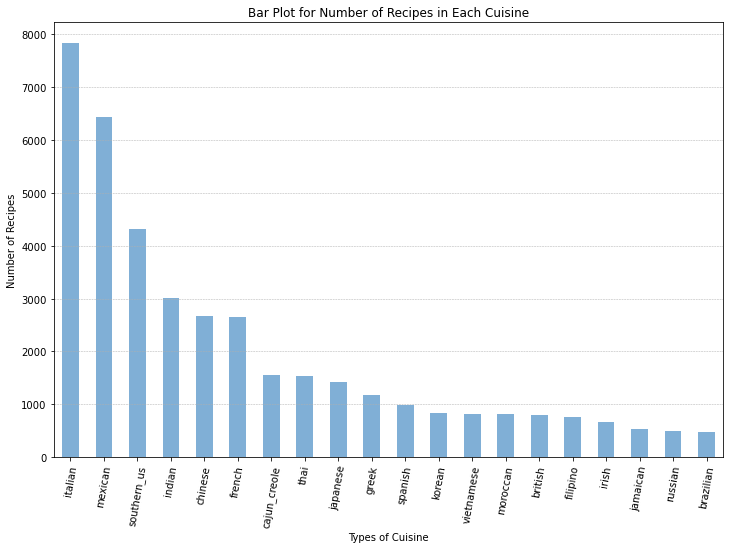

In [6]:
f, ax = plt.subplots(figsize=(12,8))
df_train.cuisine.value_counts().plot.bar(color='#80afd6')
plt.title('Bar Plot for Number of Recipes in Each Cuisine')
plt.xlabel("Types of Cuisine")
plt.ylabel("Number of Recipes")
plt.xticks(rotation=80)
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.savefig('No_of_Recipes.jpg')

### How many ingredients are present in each recipe in the training dataset?

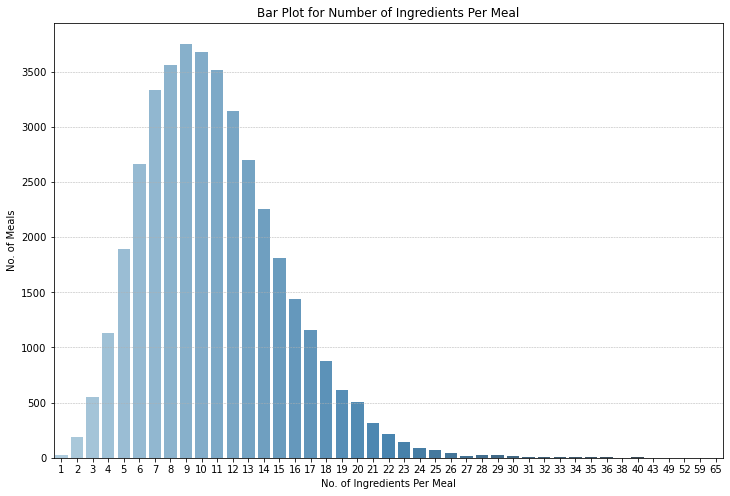

In [7]:
f, ax = plt.subplots(figsize=(12,8))
p2 = sns.barplot(x='number_ingredients_meal',
            y='number_meals',
            palette="Blues_d",
            data= (df_train.ingredients.map(lambda l: len(l))
                    .value_counts()
                    .sort_index()
                    .reset_index()
                    .rename(columns={'index':'number_ingredients_meal', 'ingredients':'number_meals'})))

p2.set_title('Bar Plot for Number of Ingredients Per Meal')
p2.set_xlabel('No. of Ingredients Per Meal')
p2.set_ylabel('No. of Meals')
p2.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
p2.figure.savefig('Ingredients_Per_Meal.jpg')

### What is the number of ingredients per cuisine in the training dataset? 

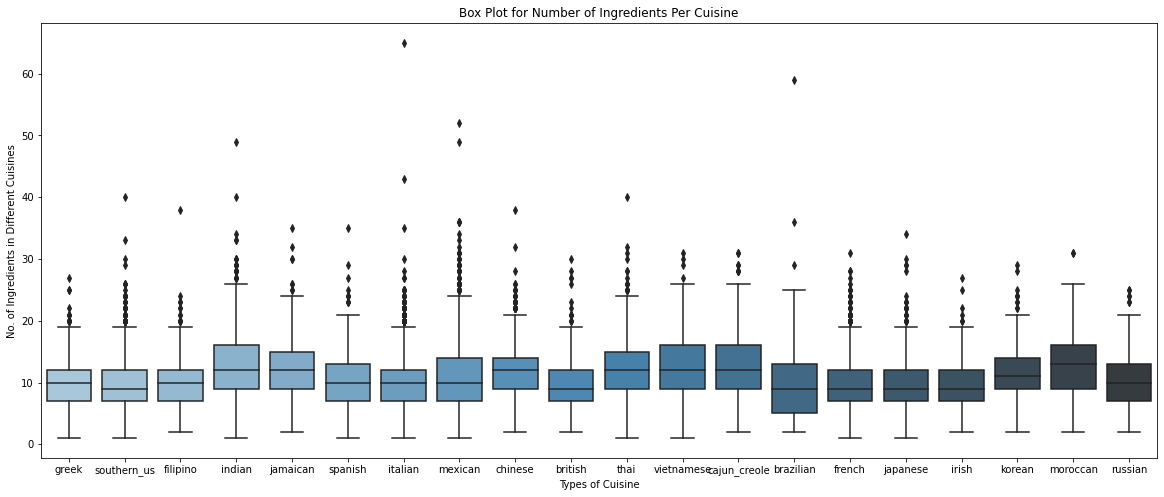

In [8]:
f, ax = plt.subplots(figsize=(20,8))
p3 = sns.boxplot(x='cuisine',
            y='number_ingredients',
            palette="Blues_d",
            data= (pd.concat([df_train.cuisine,df_train.ingredients.map(lambda l: len(l))], axis=1)
                    .rename(columns={'ingredients':'number_ingredients'})))

p3.set_title('Box Plot for Number of Ingredients Per Cuisine')
p3.set_xlabel('Types of Cuisine')
p3.set_ylabel('No. of Ingredients in Different Cuisines')
p3.figure.savefig('Ingredients_Per_Cuisine.jpg')

### What is the average number of ingredients per cuisine in the training dataset? 

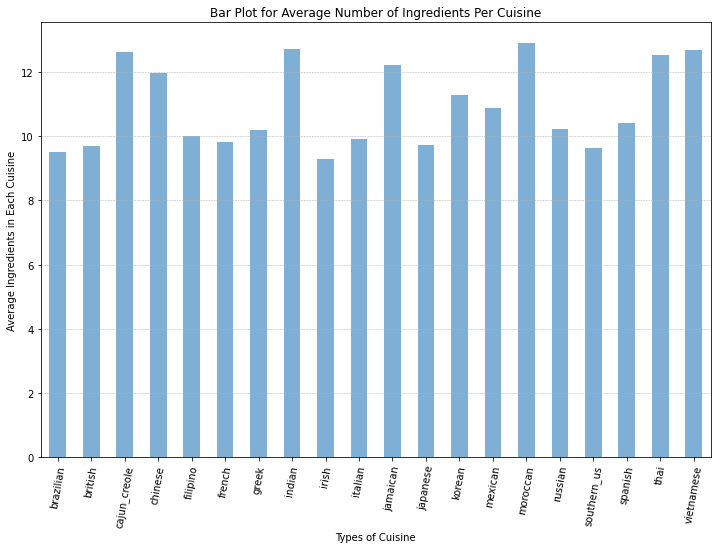

In [9]:
df_train['size'] = df_train['ingredients'].apply(len)
f, ax = plt.subplots(figsize=(12,8))
df_train.groupby('cuisine')['size'].mean().plot.bar(color='#80afd6')
plt.xticks(rotation=80)
plt.title('Bar Plot for Average Number of Ingredients Per Cuisine')
plt.xlabel('Types of Cuisine')
plt.ylabel('Average Ingredients in Each Cuisine')
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.savefig('Average_No_of_Ingredients.jpg')

### What are the most common ingredients across the cuisines in the training dataset?

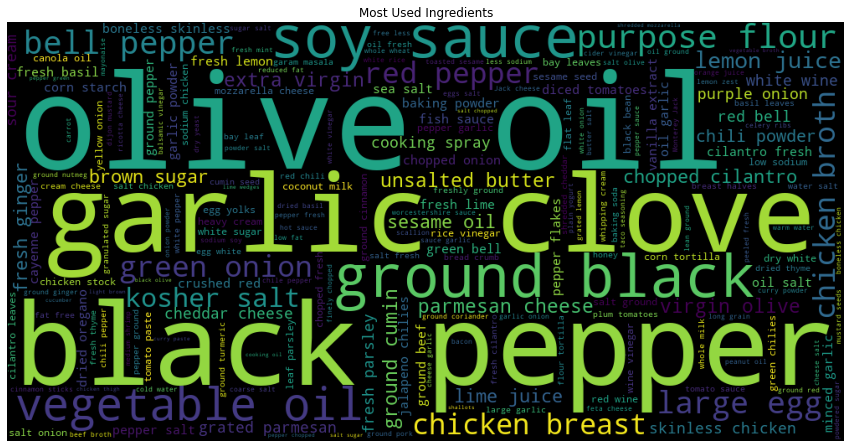

In [10]:
ingredients = pd.Series((','.join([','.join(row["ingredients"]) for ind,row in df_train.iterrows()])).split(','))
words = pd.Series(' '.join(ingredients).split())
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(words))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Most Used Ingredients")
plt.axis("off")
plt.show()

## Function to return a dictionary of unique ingredients with their frequency of occurrence.

In [11]:
def get_ingredients(dataset):
    output_dict = {}
    for i in range(dataset.shape[0]):
        for j in dataset["ingredients"][i]:
            if j in output_dict.keys():
                output_dict[j] += 1
            else:
                output_dict[j] = 1
    return output_dict

In [12]:
train_ingredients = {}
test_ingredients = {}

train_ingredients = get_ingredients(df_train)
test_ingredients = get_ingredients(df_test)

print('Number of Unique Ingredients in Train Dataset:', len(train_ingredients))
print('Number of Unique Ingredients in Test Dataset:', len(test_ingredients))

Number of Unique Ingredients in Train Dataset: 6714
Number of Unique Ingredients in Test Dataset: 4484


## Function to add missing ingredients to a dataset and set their freq. of occurrence to 0.

In [13]:
def find_missing_ingredients(first, second):
    missing = []
    for i in second.keys():
        if i not in first.keys():
            missing.append(i)
    print('Number of Missing Ingredients:', len(missing))
    for i in missing:
        first[i] = 0
    print('Number of Ingredients After Adding From the Other Dataset:', len(first))

In [14]:
find_missing_ingredients(train_ingredients, test_ingredients)
find_missing_ingredients(test_ingredients, train_ingredients)

Number of Missing Ingredients: 423
Number of Ingredients After Adding From the Other Dataset: 7137
Number of Missing Ingredients: 2653
Number of Ingredients After Adding From the Other Dataset: 7137


## Prepare the dataset to apply the model.
## Get a dataframe having all ingredients as features and recipes as data points.
## Set a particular column / feature to 1 if ingredient present in recipe, else set 0.

In [15]:
def prep_data(ingredients, dataset):
    for i in ingredients.keys():
        dataset[i] = np.zeros(len(dataset))
    for i in range(len(dataset)):
        for j in dataset['ingredients'][i]:
            dataset[j].iloc[i] = 1

In [16]:
prep_data(train_ingredients, df_train)
prep_data(test_ingredients, df_test)

In [31]:
df_train.head(3)

,id,cuisine,ingredients,romaine lettuce,black olives,grape tomatoes,garlic,pepper,purple onion,seasoning,...,bitter orange juice,Franks Wings Sauce,dried ziti,frozen peeled prawns,lovage,cooking greens,fraise,soft cheese,pork strips,shark fillets
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df_train = df_train.drop('size',axis = 1)
df_train.head(3)

,id,cuisine,ingredients,romaine lettuce,black olives,grape tomatoes,garlic,pepper,purple onion,seasoning,...,bitter orange juice,Franks Wings Sauce,dried ziti,frozen peeled prawns,lovage,cooking greens,fraise,soft cheese,pork strips,shark fillets
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_test.head()

,id,ingredients,baking powder,eggs,all-purpose flour,raisins,milk,white sugar,sugar,egg yolks,...,Daiya,curry mix,Kraft Slim Cut Mozzarella Cheese Slices,Oscar Mayer Cotto Salami,Challenge Butter,cholesterol free egg substitute,Lipton® Iced Tea Brew Family Size Tea Bags,Hidden Valley® Greek Yogurt Original Ranch® Dip Mix,tomato garlic pasta sauce,crushed cheese crackers
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35687,"[ground black pepper, salt, sausage casings, l...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Prepare the class labels (y).
## Create the training and testing splits.
## Apply Logistic Regression to predict the cuisine for the recipes in the training dataset.

In [20]:
X = df_train.drop(['id', 'ingredients', 'cuisine'], axis = 1)
y = df_train['cuisine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)
logistic_regressor = LogisticRegression()
logistic_regressor.fit(X_train, y_train)

LogisticRegression()

## Accuracy & Scores

In [21]:
train_size = []
accuracy = []

In [22]:
print('Training Accuracy:', logistic_regressor.score(X_train, y_train))
print('Testing Accuracy 1:', logistic_regressor.score(X_test, y_test))
print('Testing Accuracy 2:', accuracy_score(y_test, logistic_regressor.predict(X_test)))
train_size.append(0.8)
accuracy.append(accuracy_score(y_test, logistic_regressor.predict(X_test)))

Training Accuracy: 0.893711304566454
Testing Accuracy 1: 0.7818981772470145
Testing Accuracy 2: 0.7818981772470145


## Predict the cuisines for the recipes in the testing dataset.

In [23]:
df_test = df_test[df_train.drop('cuisine',axis = 1).columns]
df_test['cuisine'] = logistic_regressor.predict(df_test.drop(['id','ingredients'], axis = 1))

## Reposition the cuisine feature in the testing dataset from being the last to second feature.

In [24]:
temp = df_test['cuisine']
df_test.drop(labels=['cuisine'], axis=1, inplace = True)
df_test.insert(1, 'cuisine', temp)
df_test.head()

,id,cuisine,ingredients,romaine lettuce,black olives,grape tomatoes,garlic,pepper,purple onion,seasoning,...,bitter orange juice,Franks Wings Sauce,dried ziti,frozen peeled prawns,lovage,cooking greens,fraise,soft cheese,pork strips,shark fillets
0,18009,british,"[baking powder, eggs, all-purpose flour, raisi...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,28583,southern_us,"[sugar, egg yolks, corn starch, cream of tarta...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,41580,italian,"[sausage links, fennel bulb, fronds, olive oil...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29752,cajun_creole,"[meat cuts, file powder, smoked sausage, okra,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35687,italian,"[ground black pepper, salt, sausage casings, l...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# nuoc_cham = {}
# for recipe in df_train.iterrows():
#     cuisine = list(recipe)[1].at['cuisine']
#     if 'nuoc cham' in list(recipe)[1].at['ingredients']:
#         if nuoc_cham.get(cuisine):
#             nuoc_cham[cuisine] += 1
#         else:
#             nuoc_cham[cuisine] = 1
# nuoc_cham

In [26]:
# nuoc_cham = {}
# for recipe in df_test.iterrows():
#     cuisine = list(recipe)[1].at['cuisine']
#     if 'nuoc cham' in list(recipe)[1].at['ingredients']:
#         if nuoc_cham.get(cuisine):
#             nuoc_cham[cuisine] += 1
#         else:
#             nuoc_cham[cuisine] = 1
# nuoc_cham

In [27]:
X = df_train.drop(['id', 'ingredients', 'cuisine'], axis = 1)
y = df_train['cuisine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 100)
logistic_regressor = LogisticRegression()
logistic_regressor.fit(X_train, y_train)

print('Training Accuracy:', logistic_regressor.score(X_train, y_train))
print('Testing Accuracy 1:', logistic_regressor.score(X_test, y_test))
print('Testing Accuracy 2:', accuracy_score(y_test, logistic_regressor.predict(X_test)))
train_size.append(0.75)
accuracy.append(accuracy_score(y_test, logistic_regressor.predict(X_test)))

Training Accuracy: 0.8943345625209521
Testing Accuracy 1: 0.7797666934835077
Testing Accuracy 2: 0.7797666934835077


In [28]:
X = df_train.drop(['id', 'ingredients', 'cuisine'], axis = 1)
y = df_train['cuisine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)
logistic_regressor = LogisticRegression()
logistic_regressor.fit(X_train, y_train)

print('Training Accuracy:', logistic_regressor.score(X_train, y_train))
print('Testing Accuracy 1:', logistic_regressor.score(X_test, y_test))
print('Testing Accuracy 2:', accuracy_score(y_test, logistic_regressor.predict(X_test)))
train_size.append(0.7)
accuracy.append(accuracy_score(y_test, logistic_regressor.predict(X_test)))

Training Accuracy: 0.8949750368162063
Testing Accuracy 1: 0.7774239503896757
Testing Accuracy 2: 0.7774239503896757


In [29]:
X = df_train.drop(['id', 'ingredients', 'cuisine'], axis = 1)
y = df_train['cuisine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state = 100)
logistic_regressor = LogisticRegression()
logistic_regressor.fit(X_train, y_train)

print('Training Accuracy:', logistic_regressor.score(X_train, y_train))
print('Testing Accuracy 1:', logistic_regressor.score(X_test, y_test))
print('Testing Accuracy 2:', accuracy_score(y_test, logistic_regressor.predict(X_test)))
train_size.append(0.65)
accuracy.append(accuracy_score(y_test, logistic_regressor.predict(X_test)))

Training Accuracy: 0.89861911576993
Testing Accuracy 1: 0.7730048128726384
Testing Accuracy 2: 0.7730048128726384


Text(0.5, 1.0, 'Size of Training Dataset vs Accuracy for Logistic Regressor')

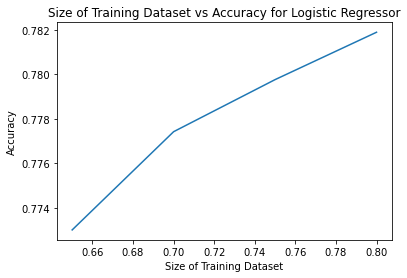

In [30]:
plt.plot(train_size, accuracy)
plt.xlabel("Size of Training Dataset")
plt.ylabel("Accuracy")
plt.title("Size of Training Dataset vs Accuracy for Logistic Regressor")